In [297]:
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib import rc
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D
import ternary
import warnings
import random
from alive_progress import alive_bar
import time

%matplotlib inline
warnings.filterwarnings('ignore')

# Benthic parameters

**Coral growth:** $r =  0.04–0.2 yr^{-1}$  *(Fung et al., 2011)*

**Coral mortality:** $mu =  0.02–0.1 yr^{-1}$  *(Fung et al., 2011)*


**Growth rate of macroalgae onto free space:** $gamma = 0.05–0.4 yr^{-1}$ *Fung et al., 2011*

**Macroalge mortality:** $pM =  0.02–1.1 yr^{-1}$ (Used values from *Fung et al., 2011* but formulation from *Cook et al., 2023*)


**Growth rate of turf onto free space:** $beta = 2–20 yr^{-1}$ *(Fung et al., 2011)*

**Turf mortality:** $pT =  0.0–1.0 yr^{-1}$  *(arbitrary)*

**Growth rate of corals onto turf relative to the rate onto free space:** $alpha1 = 0.0-1.0$ *(Fung et al., 2011)*

**Growth rate of macroalgae onto turf relative to the rate onto free space:** $alpha2 = 0–0.9$ *(Fung et al., 2011)*

**Rate of macroalgae overgrowth onto coral relative to the rate onto free space:** $alpha3 = 0–0.9$ *(Fung et al., 2011)*

# Defining ODE & parameter ranges

In [298]:
def dNdt(t, N, r, gamma, beta, alpha1, alpha2, alpha3, mu, pM, pT):
    
    C,M,T = N
    
    dC = ((r)*C*(1-C-M-T) + alpha1*r*C*T - alpha3*gamma*C*M - mu*C)*dt
    dM = ((gamma)*M*(1-C-M-T) + alpha2*gamma*T*M + alpha3*gamma*C*M - pM*M)*dt
    dT = ((beta)*T*(1-C-M-T) - alpha1*r*C*T - alpha2*gamma*T*M - pT*T)*dt

    return dC, dM, dT

# Defining PMEQ function
This function selects random values for each parameter from pristine parameter ranges defined in Fung et al., 2011* according to independent uniform distributions, while allowing me to adjust the value for macroalgae mortality (pM).

*I calculated the range of pM with a formulation from Cook et al., 2023. The range of pT is arbitrary. All other parameter ranges come from Fung et al., 2011.

In [299]:
dt = 1
NUMSTEPS = 10000
NUMYEARS = int(NUMSTEPS/dt)
time_points = np.linspace(0, NUMYEARS, NUMSTEPS+1)

C0 = 0.99
M0 = 0.005
T0 = 0.005

def PMEQ(x):
    
    outputs = []
    outputs_prime = []

    for i in range(100):

        r = np.random.uniform(0.04, 0.2, 1)[0]
        gamma = np.random.uniform(0.05, 0.4, 1)[0]
        beta = np.random.uniform(2, 20, 1)[0]
        alpha1 = np.random.uniform(0, 1, 1)[0]
        alpha2 = np.random.uniform(0, 0.9, 1)[0]
        alpha3 = np.random.uniform(0, 0.9, 1)[0]
        mu = np.random.uniform(0.02, 0.1, 1)[0]
        pM = x
        pT = np.random.uniform(0, 1, 1)[0]

        sol = solve_ivp(dNdt, [0,NUMYEARS], [C0, M0, T0], method = 'RK45', args = 
                            (r, gamma, beta, alpha1, alpha2, alpha3, mu, pM, pT), dense_output=True)

        N = sol.sol(time_points) 

        C_array = N[0,:]
        M_array = N[1,:]
        T_array = N[2,:]

        outputs.append((r, gamma, beta, alpha1, alpha2, alpha3, mu, pM, pT, C_array, M_array, T_array))
        outputs_prime.append((r, gamma, beta, alpha1, alpha2, alpha3, mu, pM, pT, C_array[-1], M_array[-1], T_array[-1]))

    df_timeseries = pd.DataFrame(outputs, columns=['r', 'gamma', 'beta', 'alpha1', 'alpha2', 'alpha3', 'mu', 'pM', 'pT', 'C_array','M_array','T_array'])
    df_prime = pd.DataFrame(outputs_prime, columns=['r', 'gamma', 'beta', 'alpha1', 'alpha2', 'alpha3', 'mu', 'pM', 'pT','C_prime','M_prime','T_prime'])
    return(df_timeseries, df_prime)

# Defining function to plot time series of each run
### This was done to ensure each parameter combination reached equilibrium.

In [300]:
def plottime(df, name):
    
    df = df[0]
    
    C_array = df['C_array']
    M_array = df['M_array']
    T_array = df['T_array']

    figure, ax = plt.subplots(ncols=3, nrows = 1, sharey=True, figsize=(40, 10))

    for i in range(100):
        ax[0].plot(C_array[i], c = 'purple')
        ax[1].plot(M_array[i], c = 'green')
        ax[2].plot(T_array[i], c = 'orange')
        
        ax[0].set_xlim(0, NUMYEARS)
        ax[1].set_xlim(0, NUMYEARS)
        ax[2].set_xlim(0, NUMYEARS)
    
        ax[0].set_title('C prime, '+str(name), fontsize = 30)
        ax[1].set_title('M prime, '+str(name), fontsize = 30)
        ax[2].set_title('T prime, '+str(name), fontsize = 30);

# Running PMEQ function and plotting time series

In [301]:
start_time = time.perf_counter()

df_pM02 = PMEQ(0.02)

end_time = time.perf_counter()
(end_time - start_time)/60

2.349946446667309

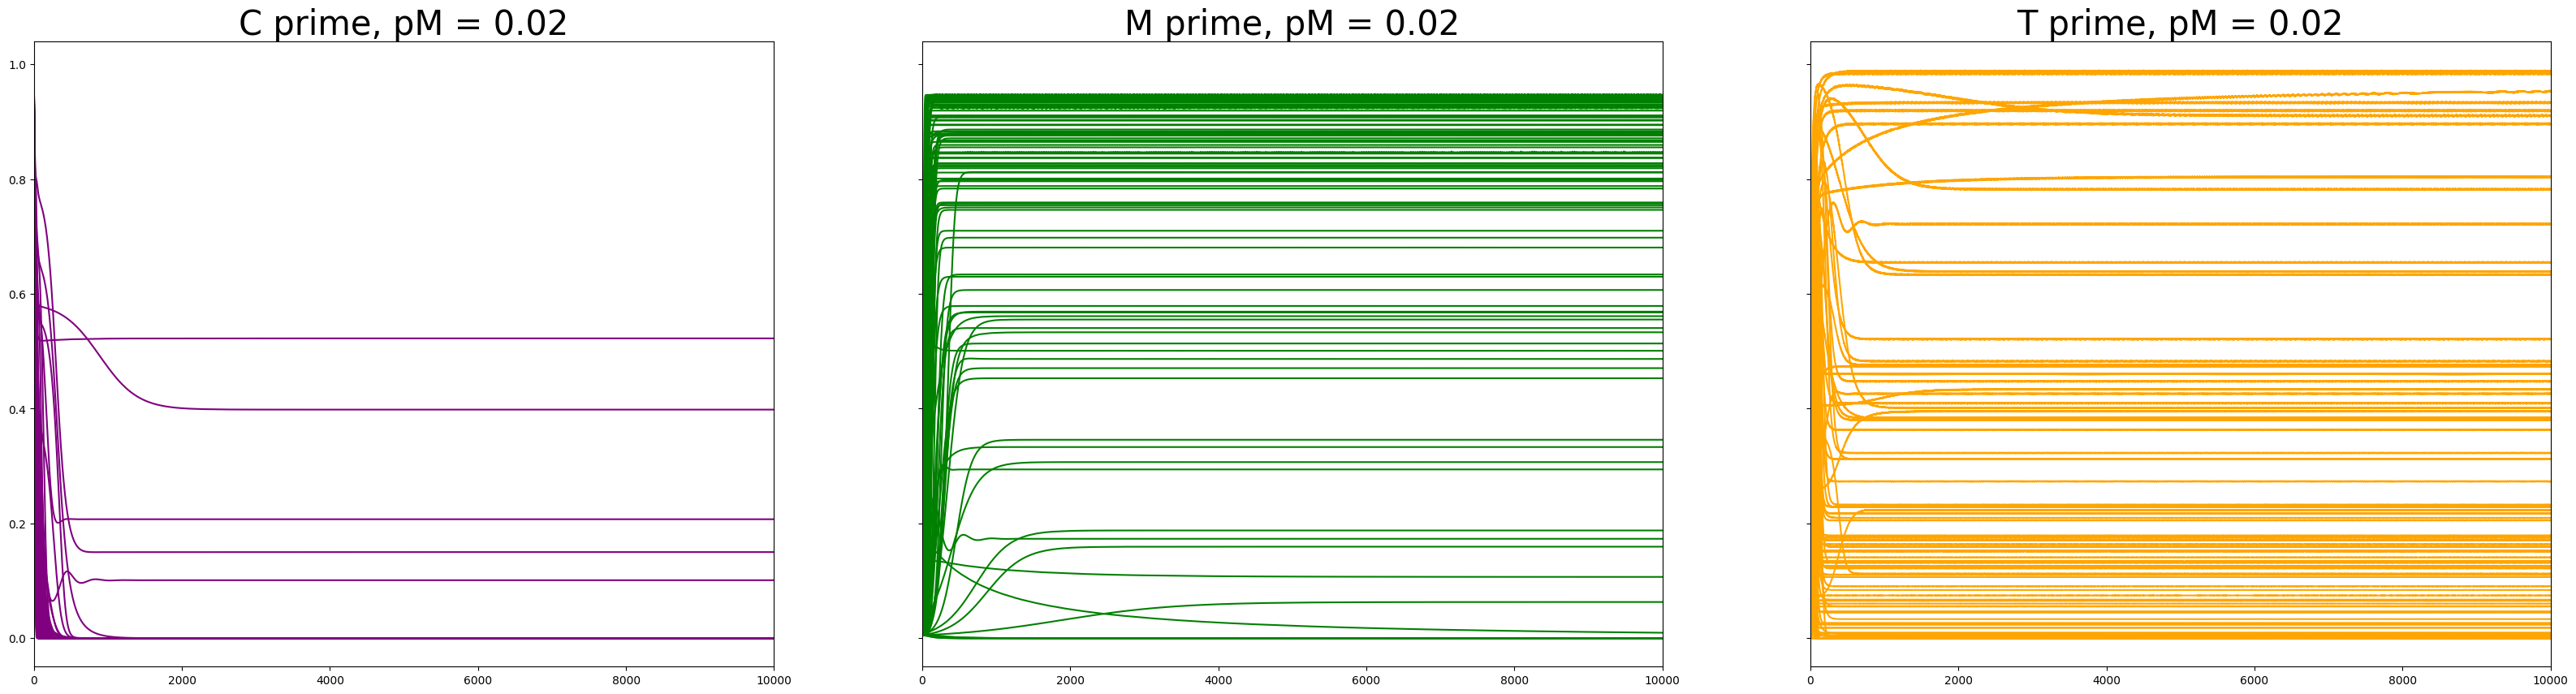

In [302]:
plottime(df_pM02, "pM = 0.02")

In [303]:
start_time = time.perf_counter()

df_pM14 = PMEQ(0.14)

end_time = time.perf_counter()
(end_time - start_time)/60

5.831806491666551

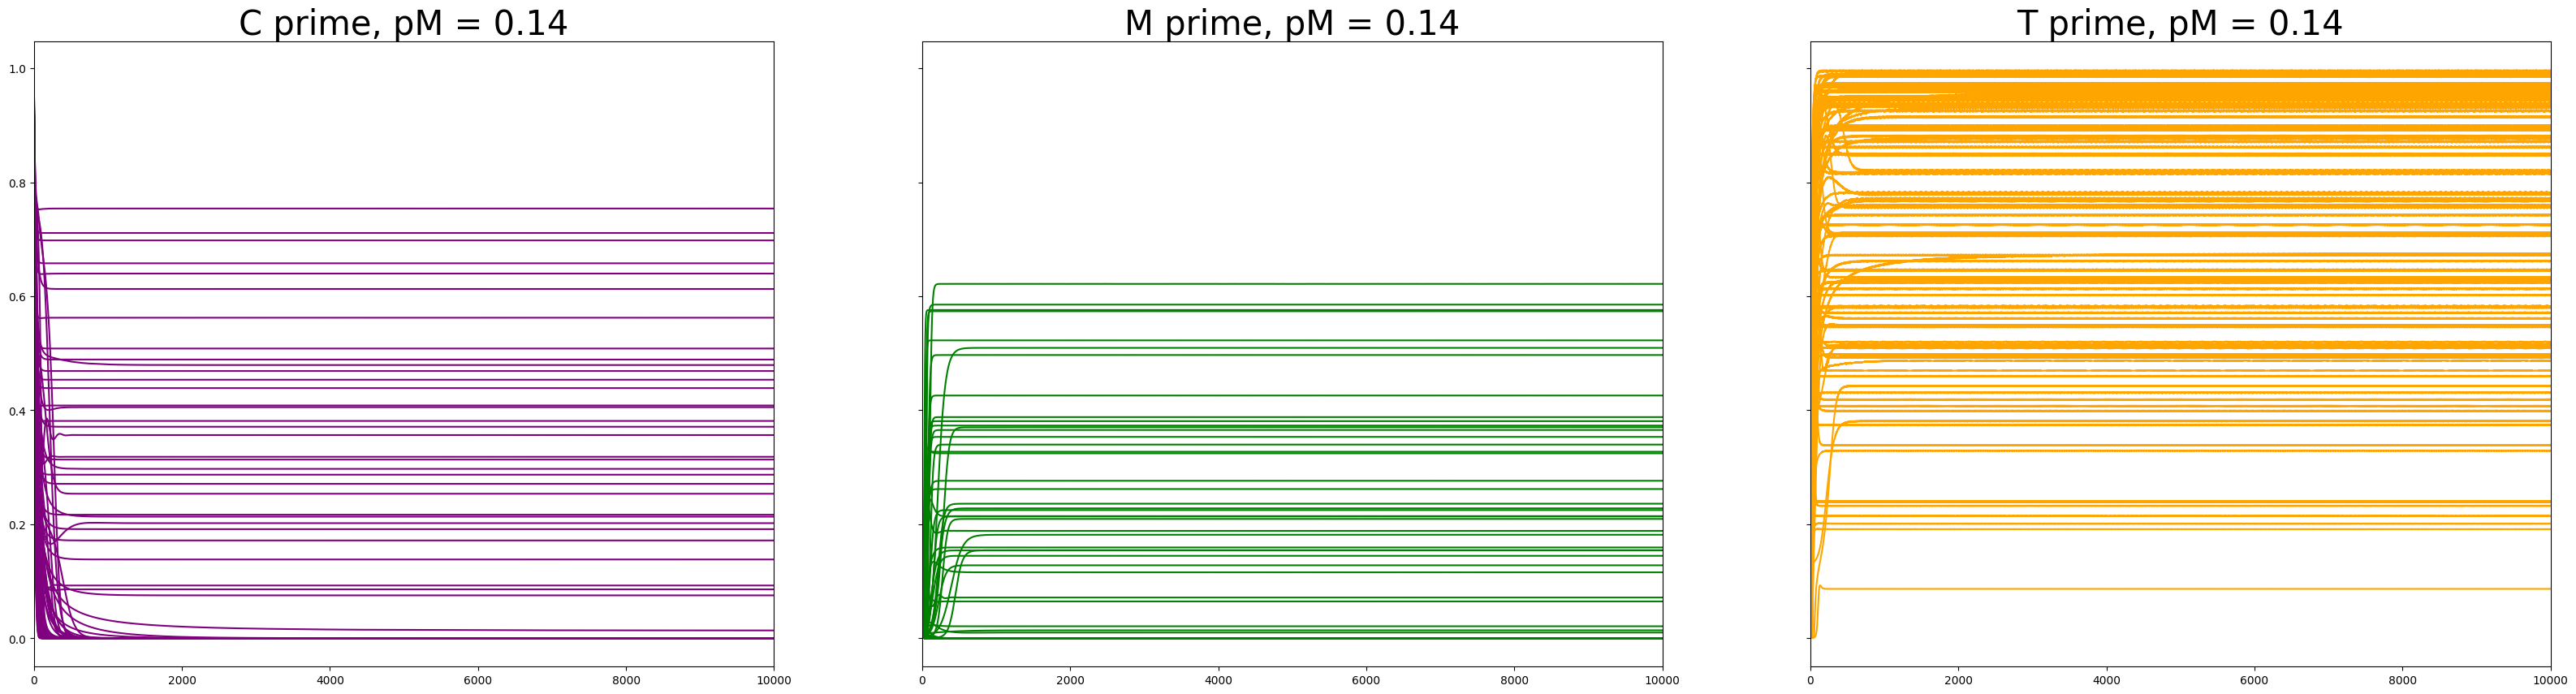

In [304]:
plottime(df_pM14, "pM = 0.14")

In [358]:
start_time = time.perf_counter()

df_pM26 = PMEQ(0.26)

end_time = time.perf_counter()
(end_time - start_time)/60

5.659519911666091

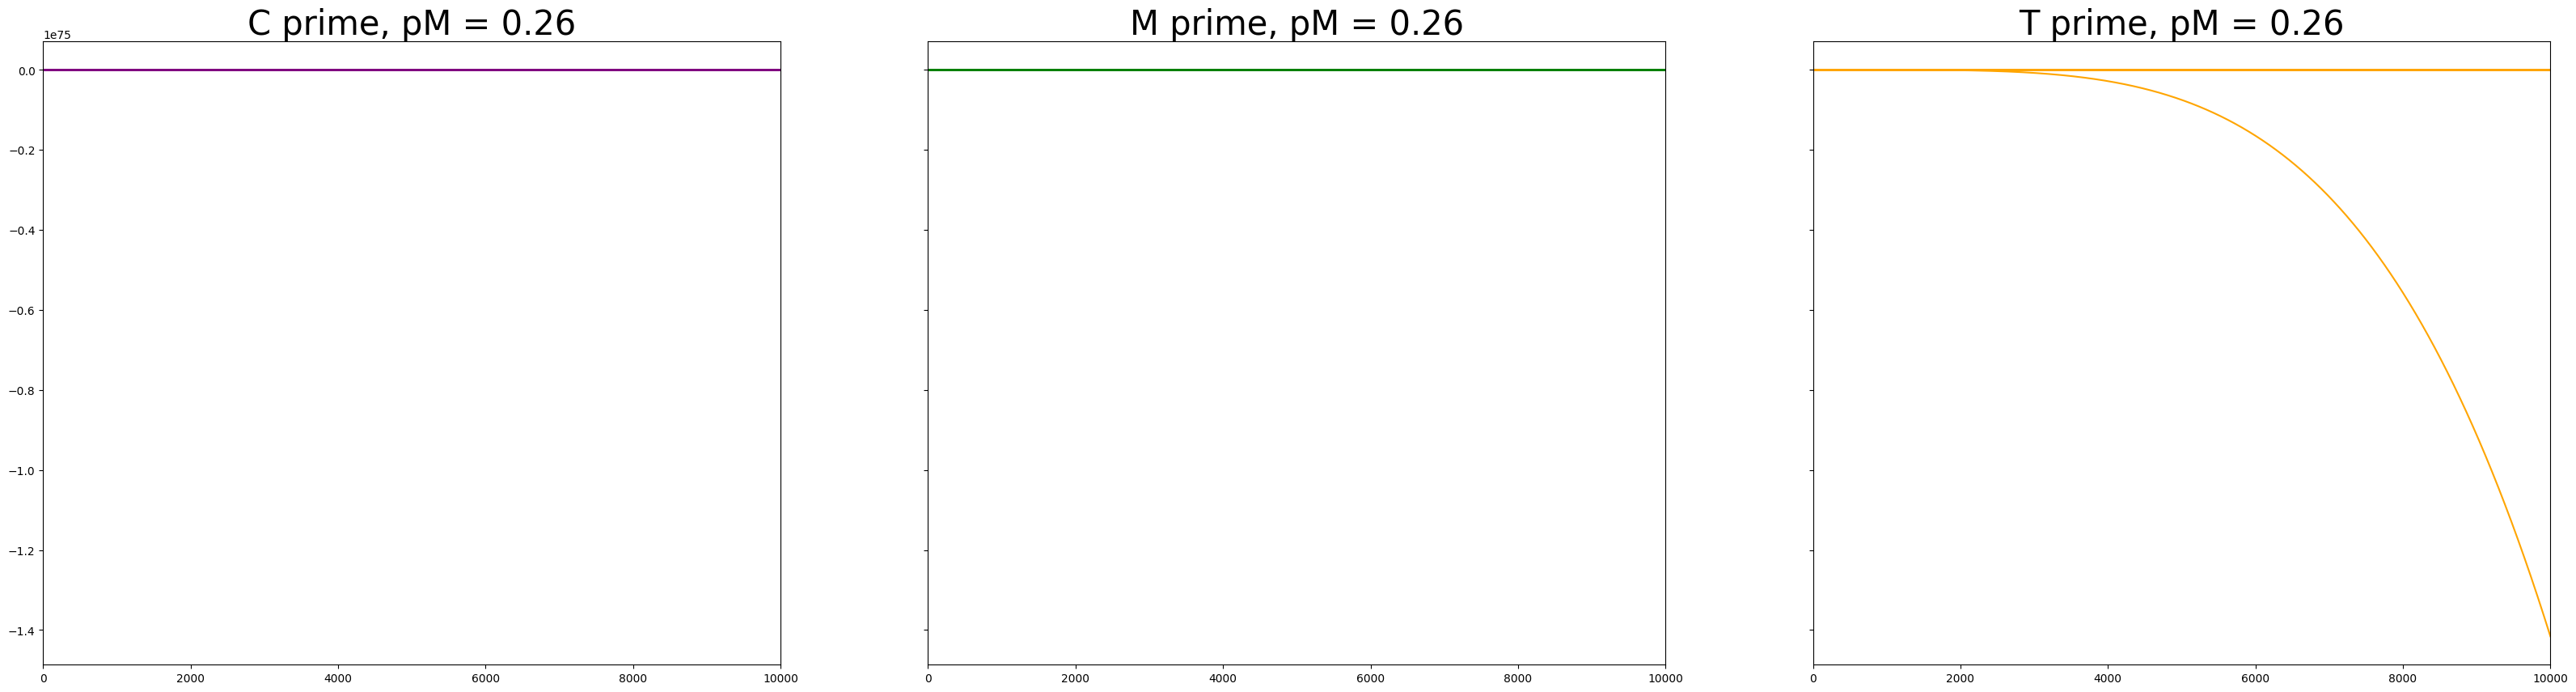

In [306]:
plottime(df_pM26, "pM = 0.26")

In [307]:
start_time = time.perf_counter()

df_pM38 = PMEQ(0.38)

end_time = time.perf_counter()
(end_time - start_time)/60

7.793457788333763

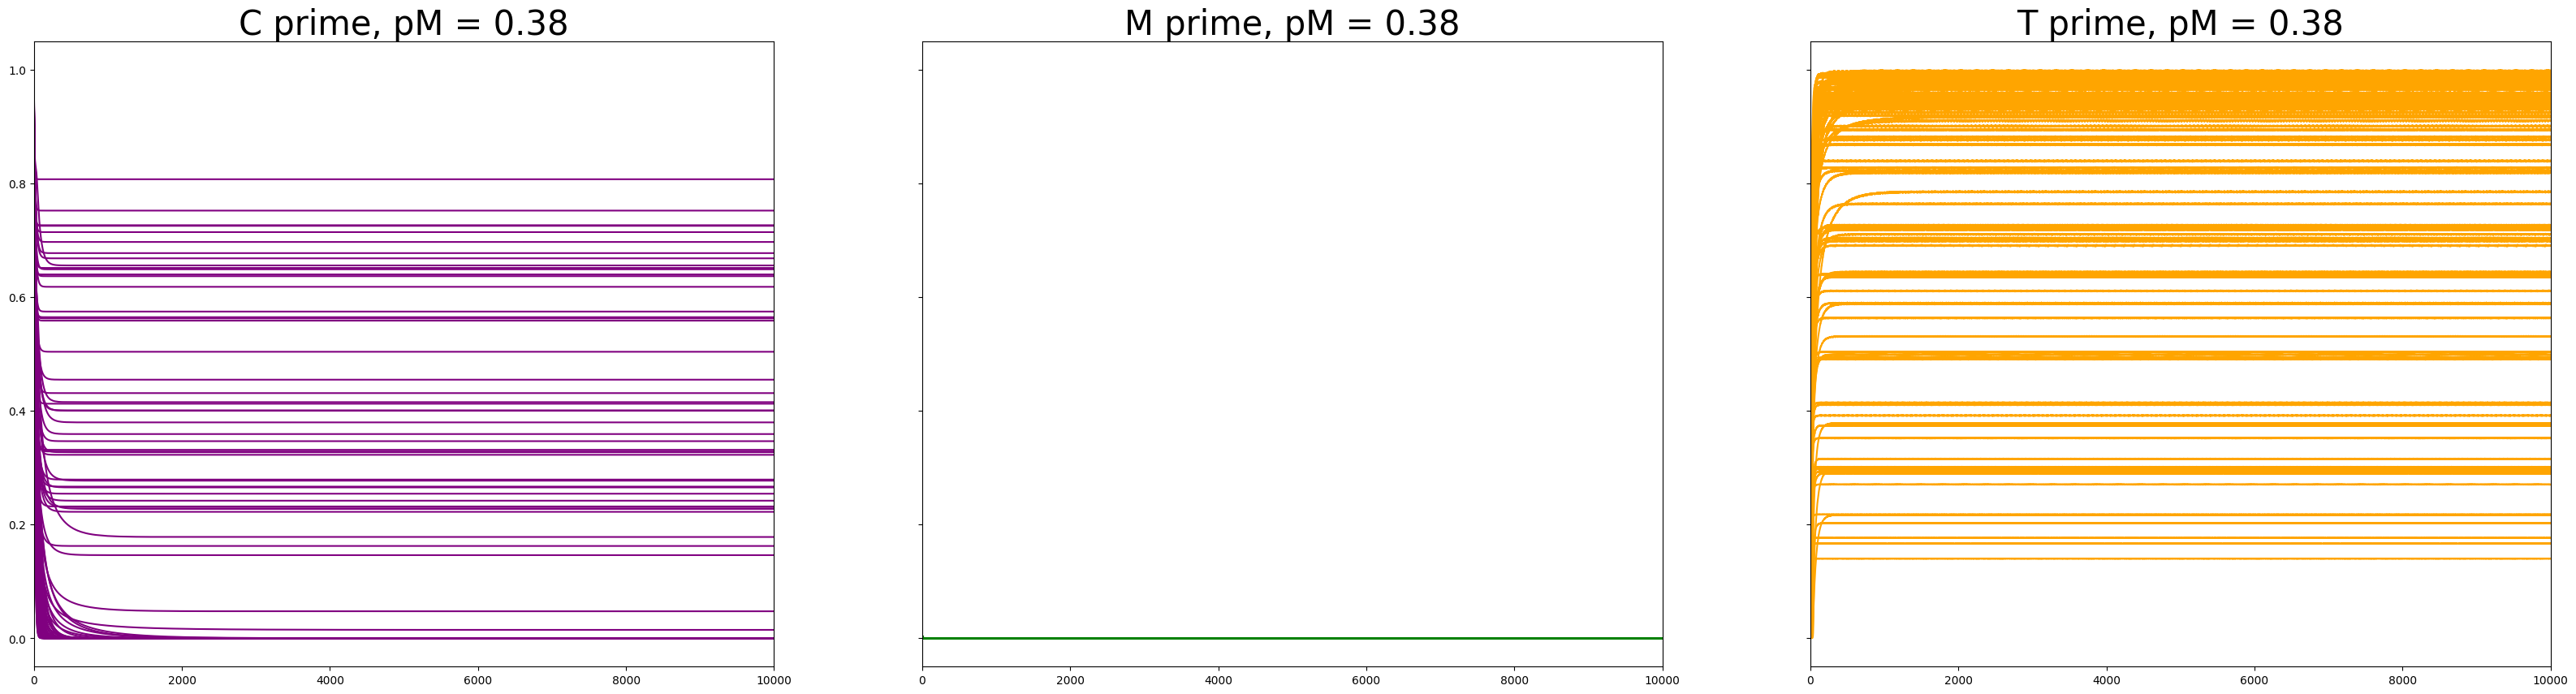

In [308]:
plottime(df_pM38, "pM = 0.38")

In [309]:
start_time = time.perf_counter()

df_pM50 = PMEQ(0.50)

end_time = time.perf_counter()
(end_time - start_time)/60

6.836159415000778

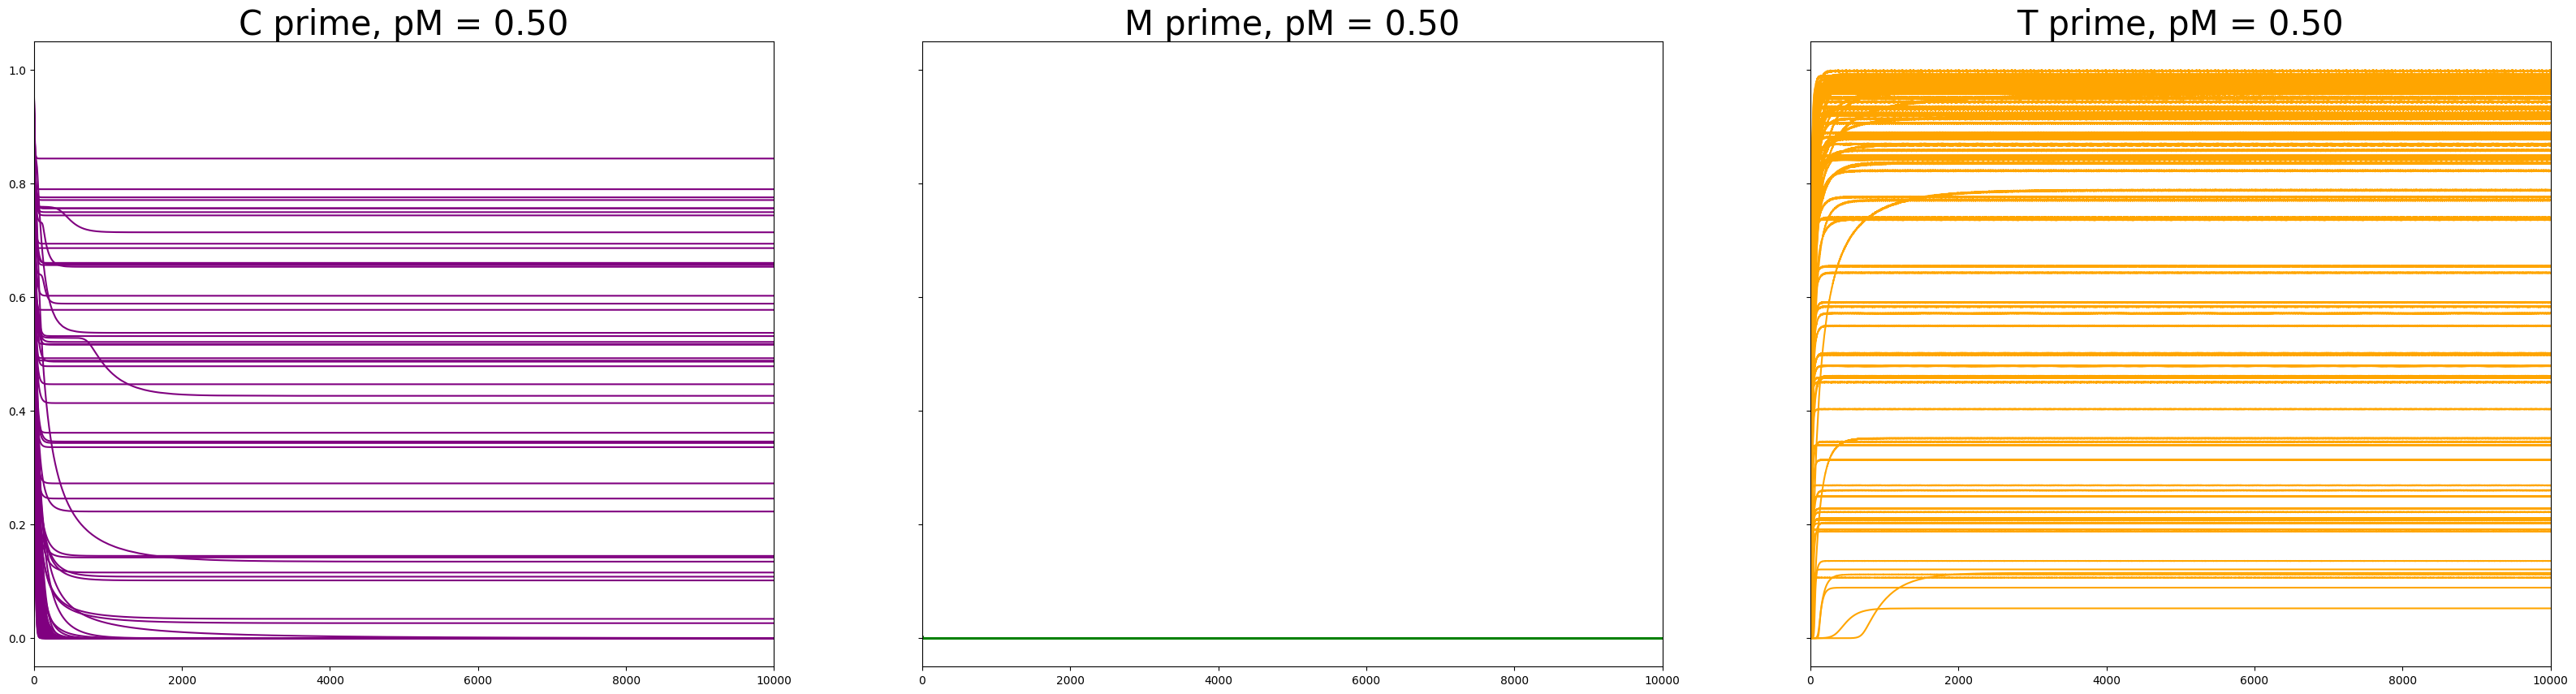

In [310]:
plottime(df_pM50, "pM = 0.50")

In [311]:
start_time = time.perf_counter()

df_pM62 = PMEQ(0.62)

end_time = time.perf_counter()
(end_time - start_time)/60

8.25334905833394

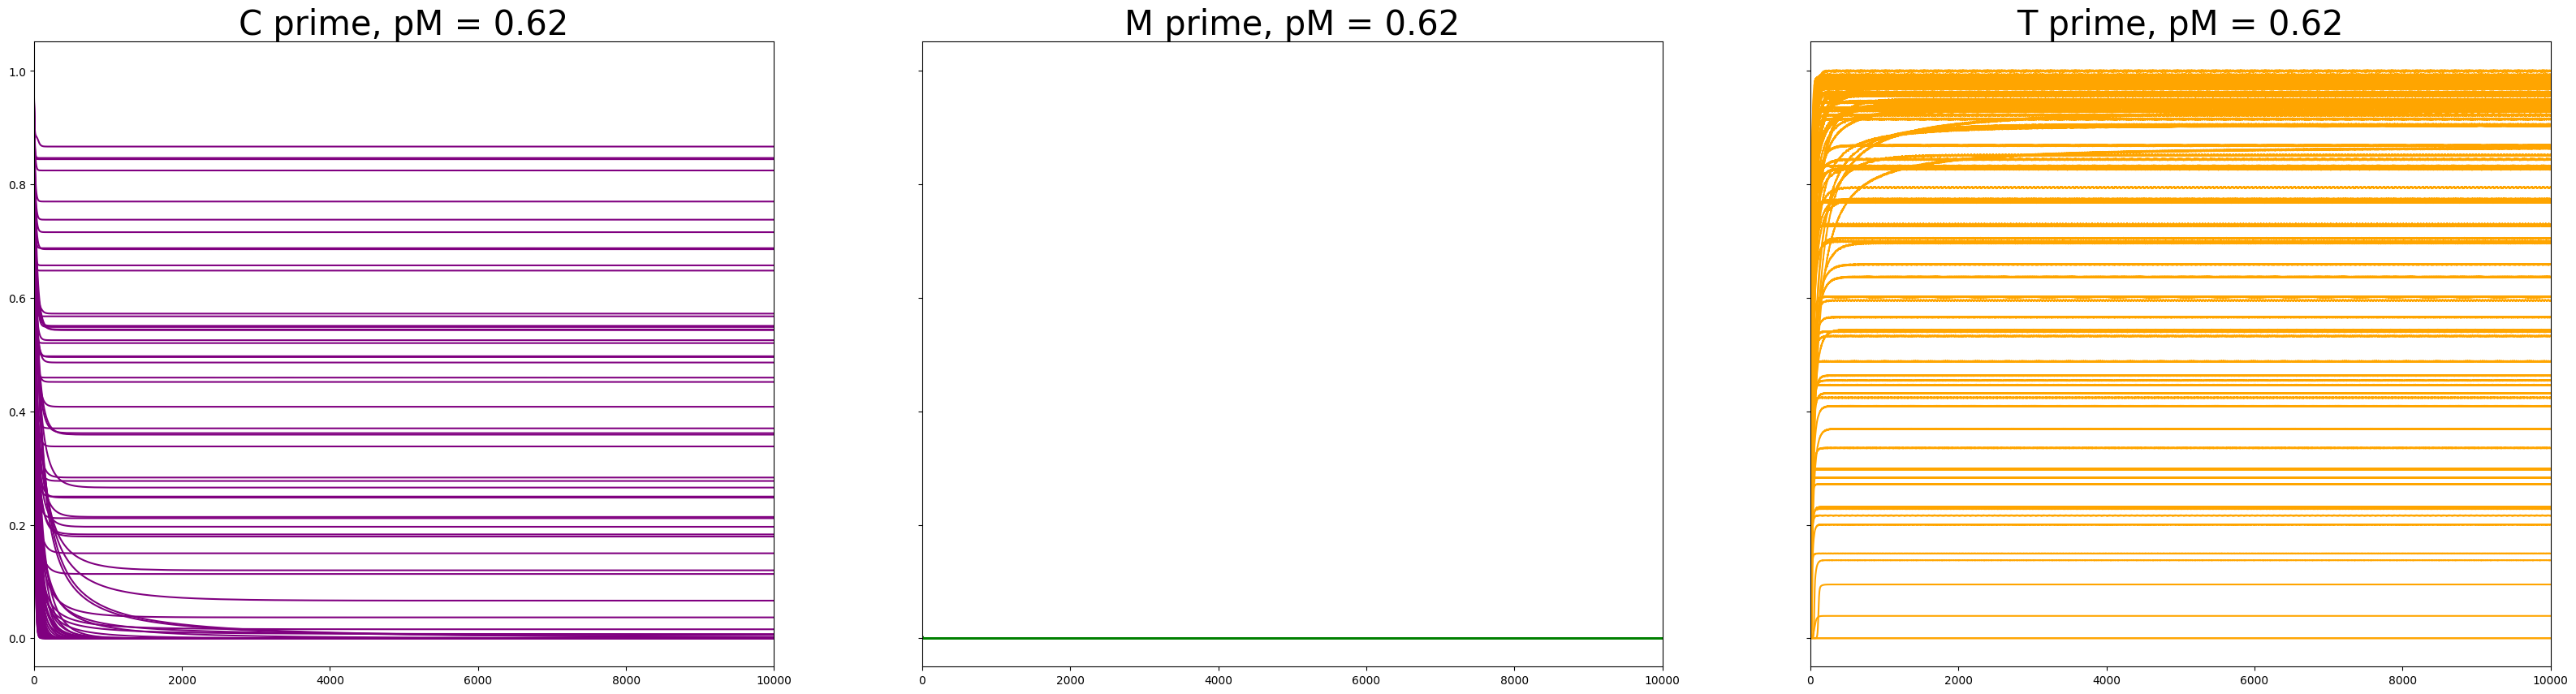

In [312]:
plottime(df_pM62, "pM = 0.62")

In [313]:
start_time = time.perf_counter()

df_pM74 = PMEQ(0.74)

end_time = time.perf_counter()
(end_time - start_time)/60

8.082397976666106

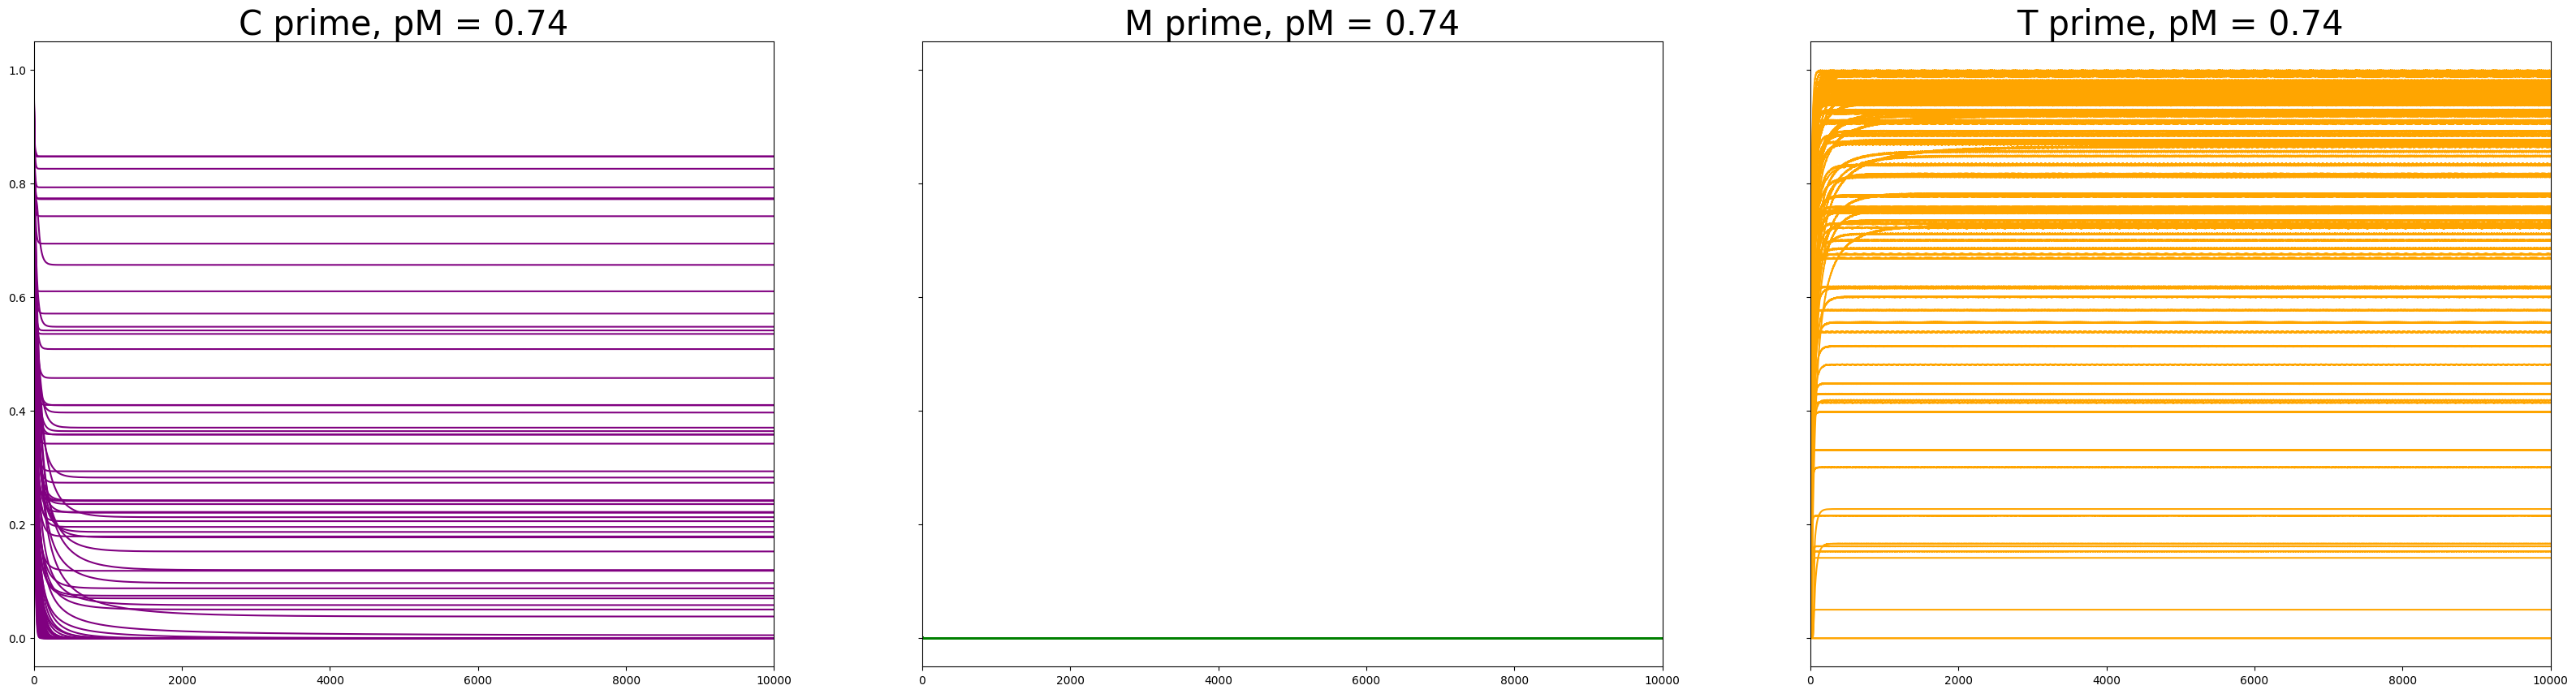

In [314]:
plottime(df_pM74, "pM = 0.74")

In [315]:
start_time = time.perf_counter()

df_pM86 = PMEQ(0.86)

end_time = time.perf_counter()
(end_time - start_time)/60

7.6268409033335045

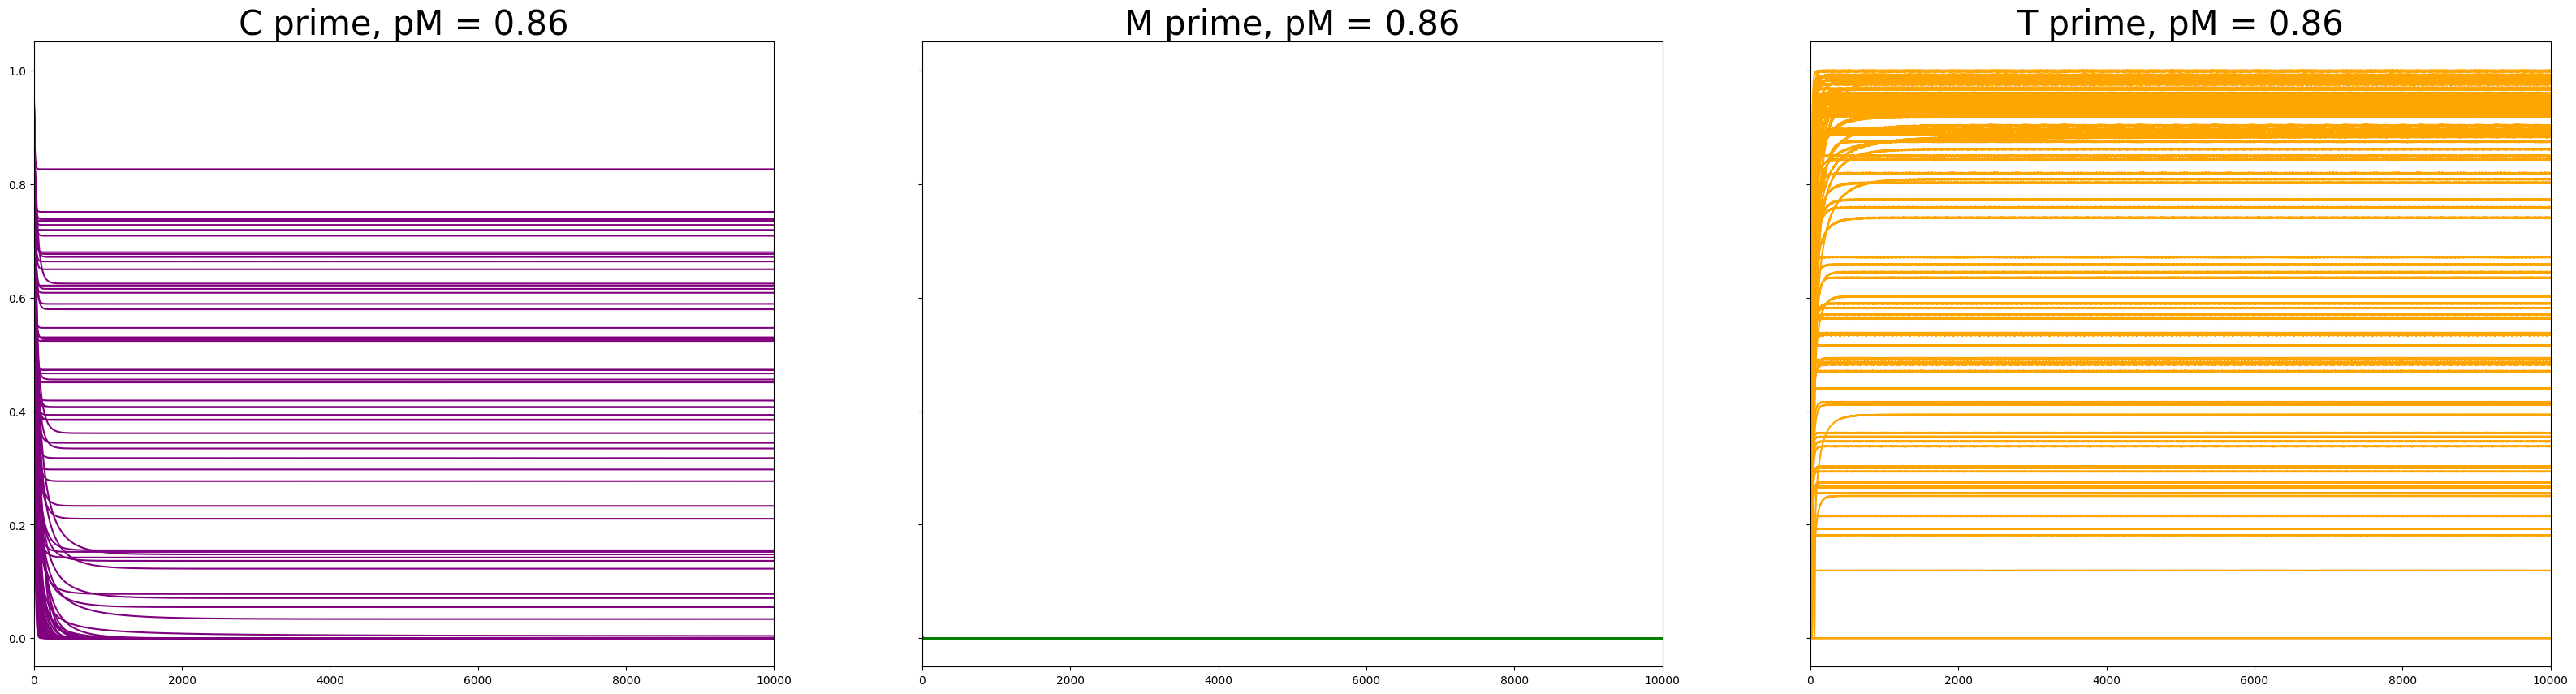

In [316]:
plottime(df_pM86, "pM = 0.86")

In [317]:
start_time = time.perf_counter()

df_pM98 = PMEQ(0.98)

end_time = time.perf_counter()
(end_time - start_time)/60

6.582833103333057

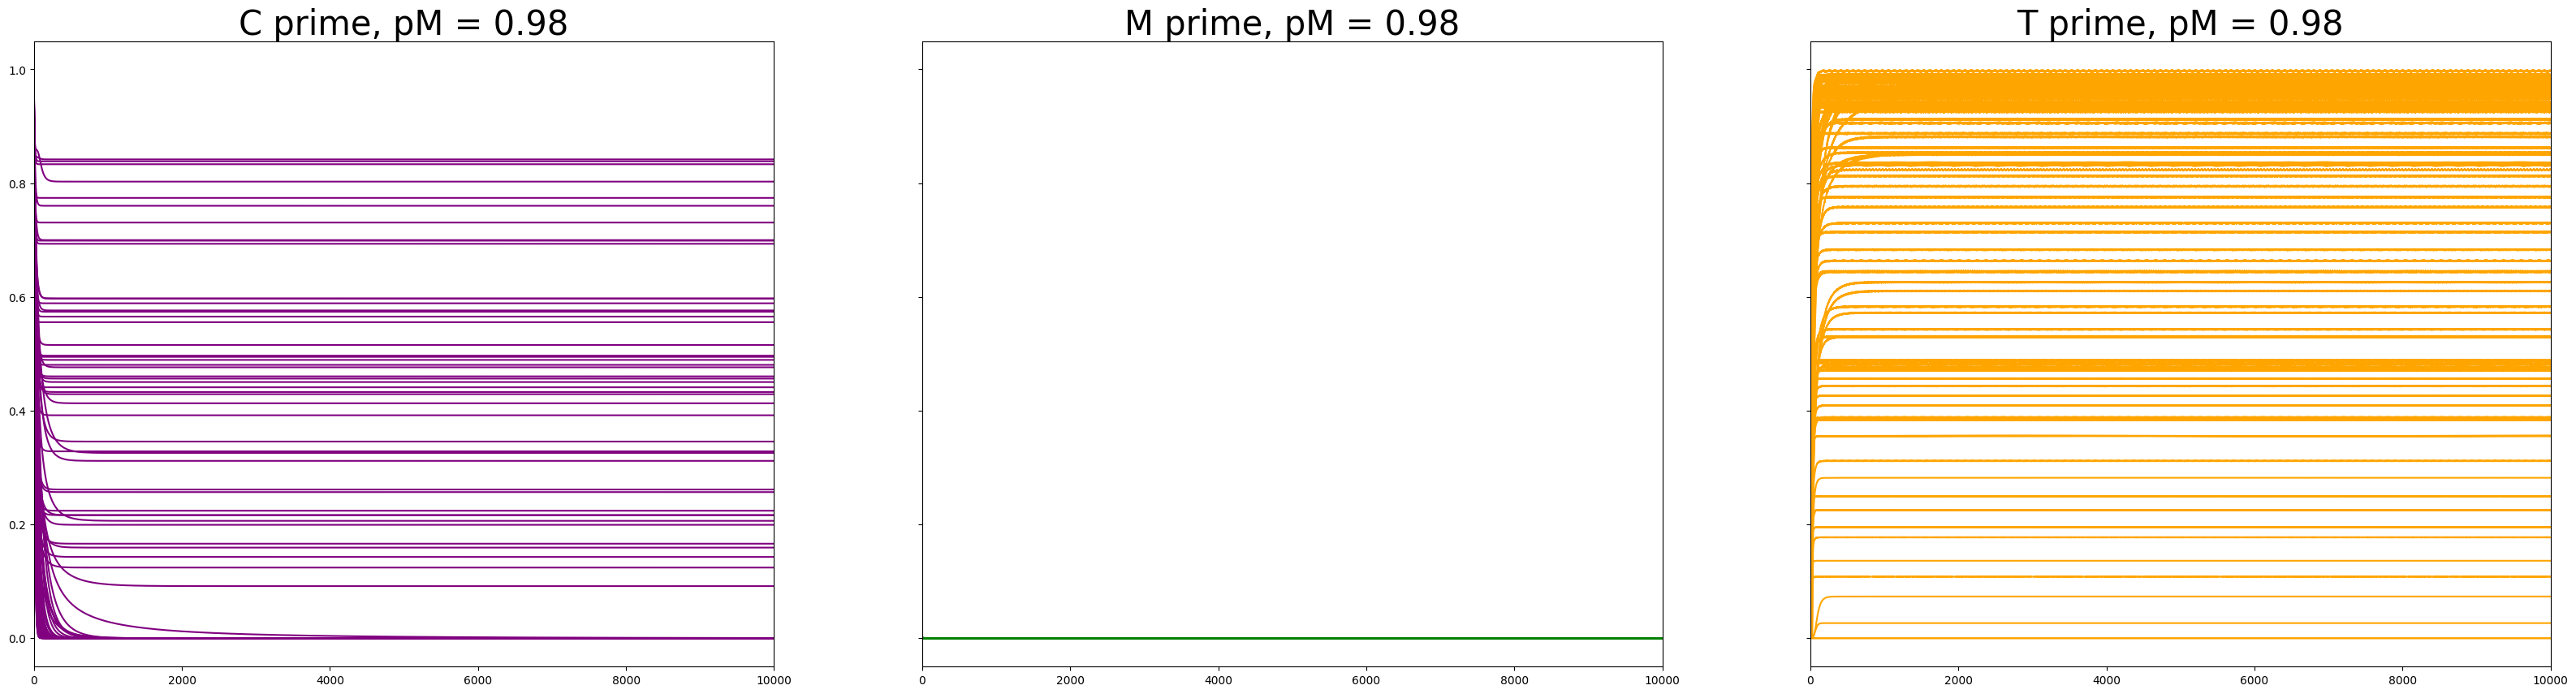

In [318]:
plottime(df_pM98, "pM = 0.98")

In [319]:
start_time = time.perf_counter()

df_p110 = PMEQ(1.1)

end_time = time.perf_counter()
(end_time - start_time)/60

7.829795884999718

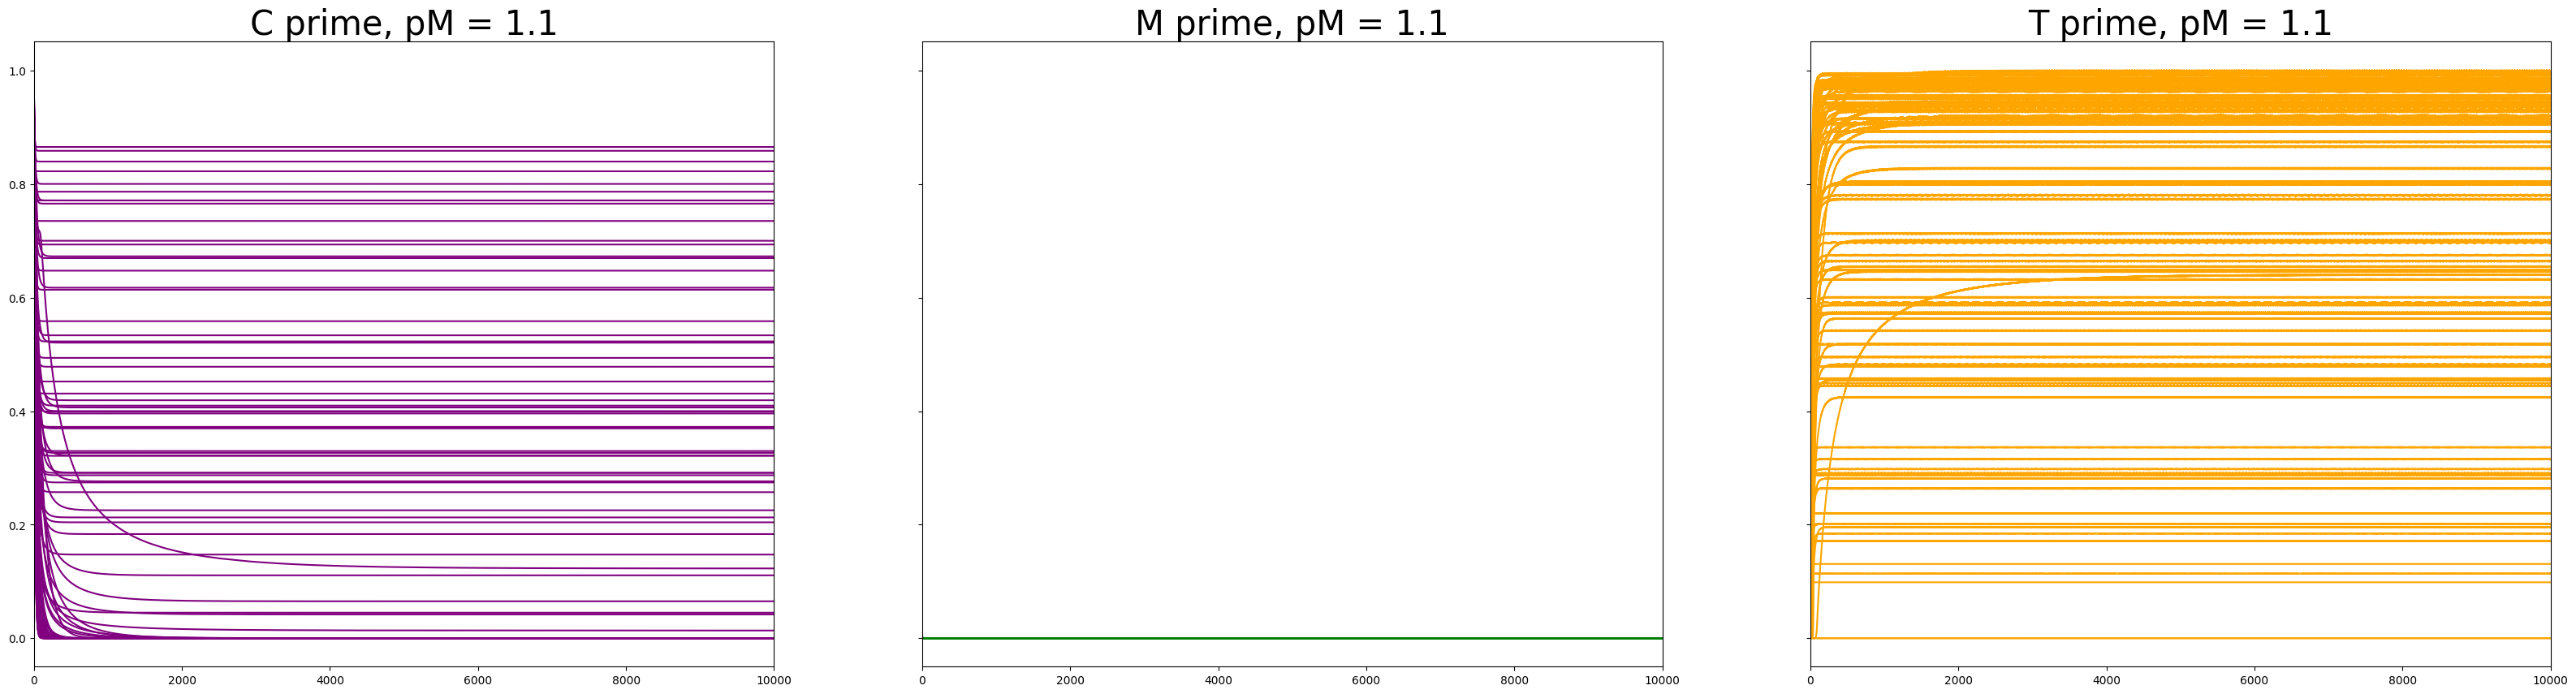

In [321]:
plottime(df_p110, "pM = 1.1")

# Defining function to find avg equilibirum benthic cover at each pM value

In [337]:
def avgfunc(pM, df):

    C_prime_avg = np.mean(df[1]['C_prime'])
    M_prime_avg = np.mean(df[1]['M_prime'])
    T_prime_avg = np.mean(df[1]['T_prime'])

    return([pM, C_prime_avg, M_prime_avg, T_prime_avg])

In [371]:
outputs = []

outputs.append(avgfunc(0.02, df_pM02))
outputs.append(avgfunc(0.14, df_pM14))
outputs.append(avgfunc(0.26, df_pM26))
outputs.append(avgfunc(0.38, df_pM38))
outputs.append(avgfunc(0.50, df_pM50))
outputs.append(avgfunc(0.62, df_pM62))
outputs.append(avgfunc(0.74, df_pM74))
outputs.append(avgfunc(0.86, df_pM86))
outputs.append(avgfunc(0.98, df_pM98))
outputs.append(avgfunc(1.1, df_p110))

avg_df = pd.DataFrame(outputs, columns=['pM', 'C_prime','M_prime','T_prime'])

# Plotting Benthic Cover at Equilibirum v. Macroalgae Mortality
### Note: when pM = 0.26, the system exploded. I was not sure how to handle it. I replotted after removing the equilibrium benthic cover values associated with pM = 0.26 to better visualize trends.

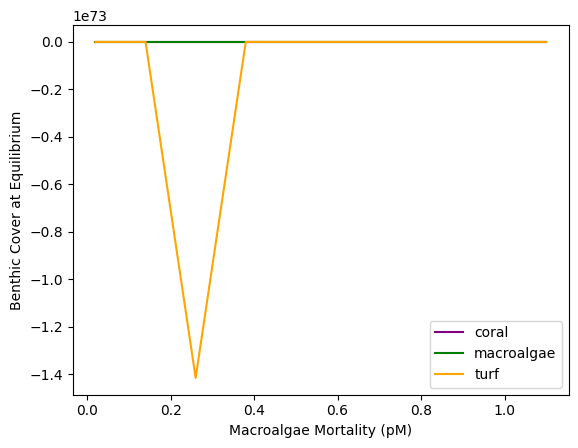

In [369]:
x = avg_df['pM']
C_prime = avg_df['C_prime']
M_prime = avg_df['M_prime']
T_prime = avg_df['T_prime']

plt.plot(x, C_prime, c = 'purple', label = 'coral')
plt.plot(x, M_prime, c = 'green', label = 'macroalgae')
plt.plot(x, T_prime, c = 'orange', label = 'turf')

plt.xlabel('Macroalgae Mortality (pM)')
plt.ylabel('Benthic Cover at Equilibrium')
plt.legend();

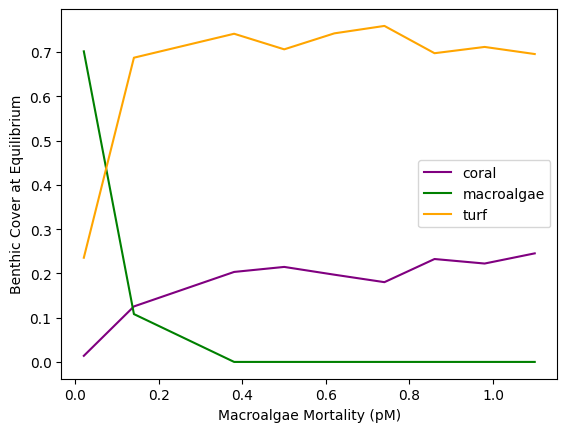

In [370]:
avg_df_no26 = avg_df[avg_df['pM'] != 0.26]

x = avg_df_no26['pM']
C_prime = avg_df_no26['C_prime']
M_prime = avg_df_no26['M_prime']
T_prime = avg_df_no26['T_prime']

plt.plot(x, C_prime, c = 'purple', label = 'coral')
plt.plot(x, M_prime, c = 'green', label = 'macroalgae')
plt.plot(x, T_prime, c = 'orange', label = 'turf')

plt.xlabel('Macroalgae Mortality (pM)')
plt.ylabel('Benthic Cover at Equilibrium')
plt.legend();